In [1]:
# to test gpu 
import tensorflow as tf 
from tensorflow.python.client import device_lib

print(tf.test.is_built_with_cuda())
print(device_lib.list_local_devices())

True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8951250657611610813
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3061265203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16223679105853863856
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Importing Librabries

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import random 
from pathlib import Path

import imageio
import skimage
import skimage.io
import skimage.transform

# ML
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics


#tensorflow
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy

In [3]:
#setting random seed
from numpy.random import seed
seed(101)
tensorflow.random.set_seed(101)

In [4]:
import os

data_path = os.path.join('c:' + os.sep, 'Users', 'uttam', 'Desktop', 'DS', 'honey_bees_classifier','Dataset')
print(data_path)

c:\Users\uttam\Desktop\DS\honey_bees_classifier\Dataset


In [5]:
# Global variables
img_folder=os.path.join(data_path+os.sep+'bee_imgs\\')
img_width=100
img_height=100
img_channels=3

In [6]:
img_folder

'c:\\Users\\uttam\\Desktop\\DS\\honey_bees_classifier\\Dataset\\bee_imgs\\'

In [7]:
df=pd.read_csv(os.path.join(data_path+os.sep+'bee_data.csv'), 
                index_col=False,  
                parse_dates={'datetime':[1,2]},
                dtype={'subspecies':'category', 'health':'category','caste':'category'})

In [8]:
df.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [9]:
df.shape

(5172, 8)

In [10]:
def read_img(file):
    img = skimage.io.imread(img_folder + file)
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    return img[:,:,:img_channels]

In [11]:
read_img('041_066.png')

array([[[0.83398824, 0.94147059, 0.63699216],
        [0.83892157, 0.93798824, 0.64734118],
        [0.83939216, 0.93831373, 0.64039216],
        ...,
        [0.91892157, 0.99843137, 0.74480392],
        [0.92112941, 0.99606667, 0.74524314],
        [0.91744706, 0.99578431, 0.74872549]],

       [[0.83557647, 0.94538039, 0.64495686],
        [0.83702353, 0.94682745, 0.65258824],
        [0.84245098, 0.9522549 , 0.65578431],
        ...,
        [0.91529412, 0.99843137, 0.74117647],
        [0.91764706, 0.99592157, 0.74509804],
        [0.91498039, 0.99215686, 0.74509804]],

       [[0.83654902, 0.94729412, 0.64737255],
        [0.84298039, 0.95572549, 0.66013725],
        [0.84460784, 0.96117647, 0.66264706],
        ...,
        [0.91529412, 0.99843137, 0.74117647],
        [0.91764706, 0.99592157, 0.74509804],
        [0.91498039, 0.99215686, 0.74509804]],

       ...,

       [[0.48429412, 0.46468627, 0.45543137],
        [0.51170588, 0.49209804, 0.48958824],
        [0.47941176, 0

## Check for missing data

In [12]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(df)

,Total,Percent
caste,0,0.0
pollen_carrying,0,0.0
health,0,0.0
subspecies,0,0.0
zip code,0,0.0
location,0,0.0
file,0,0.0
datetime,0,0.0


In [13]:
# Some image files don't exist. Leave only bees with available images.
img_exists = df['file'].apply(lambda f: os.path.exists(img_folder + f))
df= df[img_exists]

In [14]:
img_exists

0       True
1       True
2       True
3       True
4       True
        ... 
5167    True
5168    True
5169    True
5170    True
5171    True
Name: file, Length: 5172, dtype: bool

In [15]:
df.shape # images shape is same as previous hence all images exists

(5172, 8)

##  EDA

The data contains the following values:

* file - the image file name;

* date - the date when the picture was taken;

* time - the time when the picture was taken;

* location - the US location, with city, state and country names;

* zip code - the ZIP code associated with the location;

* subspecies - the subspecies to whom the bee in the current image belongs;

* health - this is the health state of the bee in the current image;

* pollen_carrying - indicates if the picture shows the bee with pollen attached to the legs;

* caste - the bee caste;

In [16]:
# location wise imaes counts
tmp = df.groupby(['zip code'])['location'].value_counts()
df_loc = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df_loc

,zip code,location,Images
0,3431,"Keene, NH, USA",92
1,30607,"Athens, GA, USA",579
2,30607,"Athens, Georgia, USA",472
3,50315,"Des Moines, IA, USA",973
4,70115,"New Orleans, LA, USA",170
5,77511,"Alvin, TX, USA",737
6,95070,"Saratoga, CA, USA",2000
7,95124,"San Jose, CA, USA",149


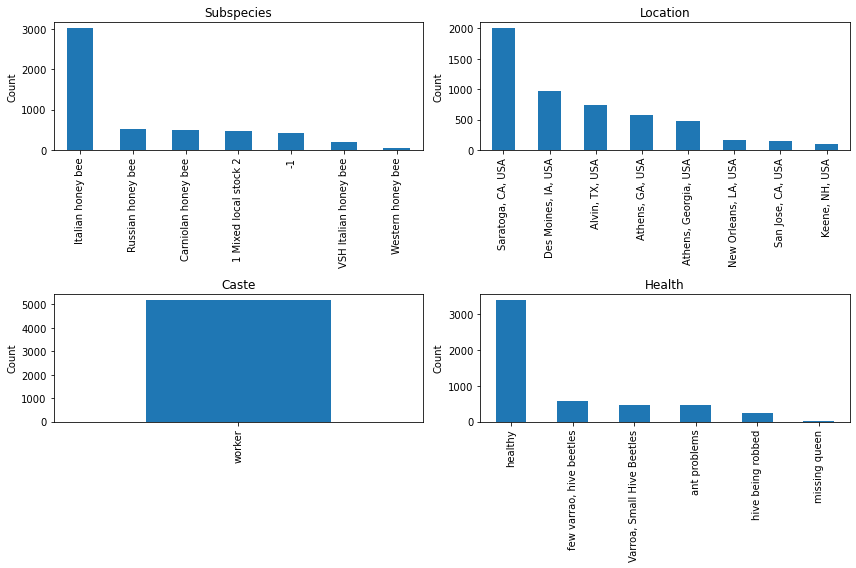

In [17]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

df.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Subspecies')

df.location.value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0,1].set_title('Location')
ax[0,1].set_ylabel('Count')

df.caste.value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1,0].set_title('Caste')
ax[1,0].set_ylabel('Count')

df.health.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Health')
ax[1,1].set_ylabel('Count')

f.subplots_adjust(hspace=0.7)
f.tight_layout()
plt.show()

Subspecies are not balanced hence we have to do downsapling 

## Bees Images Visualization

In [18]:
subspecies= df['subspecies'].cat.categories

In [19]:
subspecies #we have s7 cat. of bees

Index(['-1', '1 Mixed local stock 2', 'Carniolan honey bee',
       'Italian honey bee', 'Russian honey bee', 'VSH Italian honey bee',
       'Western honey bee'],
      dtype='object')

In [20]:
img_folder+df[df['subspecies']== '-1'].iloc[0]['file']

'c:\\Users\\uttam\\Desktop\\DS\\honey_bees_classifier\\Dataset\\bee_imgs\\041_066.png'

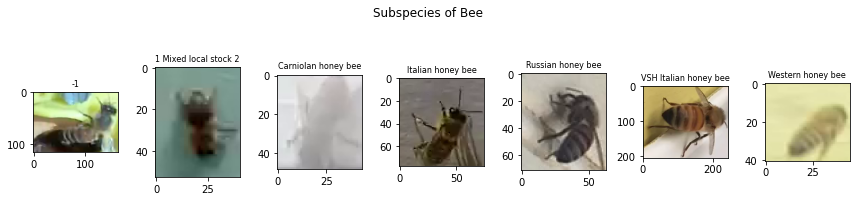

In [21]:
f, ax = plt.subplots(nrows=1,ncols=subspecies.size, figsize=(12,3))

i=0
# Draw the first found bee of given subpecies
for s in subspecies:
    file=img_folder + df[df['subspecies']==s].iloc[0]['file']
    im=imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=8)
    i+=1
    
plt.suptitle("Subspecies of Bee")
plt.tight_layout()
plt.show()

In [22]:
df.health.value_counts()

healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64

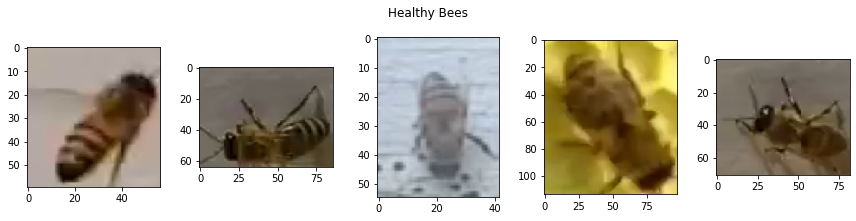

In [23]:
ncols = 5
df_healthy = df[df['health'] == 'healthy'].sample(ncols)

f, ax = plt.subplots(nrows=1,ncols=ncols, figsize=(12,3))
# Read image of original size from disk, because bees['img'] contains resized numpy array
for i in range(0,5): 
    file = img_folder + df_healthy.iloc[i]['file']
    ax[i].imshow(imageio.imread(file))

plt.suptitle("Healthy Bees")
plt.tight_layout()
plt.show()

In [24]:
health_cats = df['health'].cat.categories
health_cats

Index(['Varroa, Small Hive Beetles', 'ant problems',
       'few varrao, hive beetles', 'healthy', 'hive being robbed',
       'missing queen'],
      dtype='object')

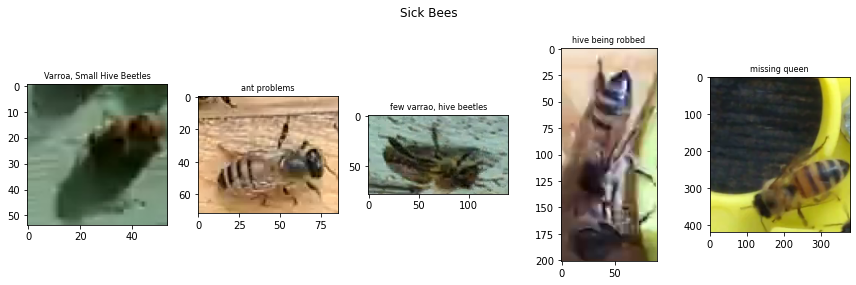

In [25]:
f, ax = plt.subplots(1, health_cats.size-1, figsize=(12,4))
i=0
for c in health_cats:
    if c == 'healthy': continue
    df_bee = df[df['health'] == c].sample(1).iloc[0]
    ax[i].imshow(imageio.imread(img_folder + df_bee['file']))
    ax[i].set_title(df_bee['health'], fontsize=8)
    i += 1
    
plt.suptitle("Sick Bees")    
plt.tight_layout()
plt.show()

In [26]:
df.columns

Index(['datetime', 'file', 'location', 'zip code', 'subspecies', 'health',
       'pollen_carrying', 'caste'],
      dtype='object')

In [27]:
df["year"] = df['datetime'].dt.year
df["month"] = df['datetime'].dt.month
df["day"] = df['datetime'].dt.day
df["minute"] = df['datetime'].dt.minute

In [28]:
df.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste,year,month,day,minute
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,2018,8,28,7
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,2018,8,28,7
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,2018,8,28,7
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,2018,8,28,7
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,2018,8,28,7


## Pollen Carrying 

In [29]:
tmp = df.groupby(['pollen_carrying'])['year'].value_counts()
df_pollen = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df_pollen

,pollen_carrying,year,Images
0,False,2018,5154
1,True,2018,18


In [30]:
tmp = df.groupby(['pollen_carrying'])['subspecies'].value_counts()
df_pollen_true = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df_pollen_true[df_pollen_true['pollen_carrying']==True]

,pollen_carrying,subspecies,Images
7,True,-1,12
8,True,Italian honey bee,6


Only 18 out of 5172 (0.34%) of the images are of bees carrying pollen.
Majority of pollen carrying bees are of unknown species (67%) and the rest (33%) are Italian honey bee

## Bee Subspecies classification

* Data Processing : Balancing samples by subspecies by downsampling

   Split all Bees to train, validation and test. 
   
   Then balance train dataset. Splitting should be done before balancing to avoid putting the same upsampled Bee to both train and test.

In [31]:
df.subspecies.value_counts() #we have more samples fro italinan bee hence we need to perform downsaampling 

Italian honey bee        3008
Russian honey bee         527
Carniolan honey bee       501
1 Mixed local stock 2     472
-1                        428
VSH Italian honey bee     199
Western honey bee          37
Name: subspecies, dtype: int64

In [32]:
df['subspecies'].cat.categories.size

7

In [33]:
def split_balance(df, field_name):
    """ 
    Split to train, test and validation. 
    Then balance train by given field name.
    Draw plots before and after balancing
    
    @param df: Total Bees dataset to balance and split
    @param field_name: Field to balance by
    @return:  balanced train bees, validation bees, test bees
    """
    # Split to train and test before balancing
    train_bees, test_bees = train_test_split(df, random_state=24)

    # Split train to train and validation datasets
    # Validation for use during learning
    train_bees, val_bees = train_test_split(train_bees, test_size=0.1, random_state=24)

    #Balance by subspecies to train_bees_bal_ss dataset
    # Number of samples in each category
    ncat_bal = int(len(train_bees)/train_bees[field_name].cat.categories.size)
    train_bees_bal = train_bees.groupby(field_name, as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True)).reset_index(drop=True)
    return(train_bees_bal, val_bees, test_bees)

In [34]:
train_bees_bal, val_bees, test_bees=split_balance(df, 'subspecies')


In [35]:
train_bees_bal['subspecies'].value_counts()

Western honey bee        498
VSH Italian honey bee    498
Russian honey bee        498
Italian honey bee        498
Carniolan honey bee      498
1 Mixed local stock 2    498
-1                       498
Name: subspecies, dtype: int64

In [36]:
val_bees['subspecies'].value_counts()

Italian honey bee        238
Russian honey bee         38
-1                        36
1 Mixed local stock 2     33
Carniolan honey bee       30
VSH Italian honey bee     12
Western honey bee          1
Name: subspecies, dtype: int64

In [37]:
test_bees['subspecies'].value_counts()

Italian honey bee        754
Carniolan honey bee      147
Russian honey bee        124
-1                       108
1 Mixed local stock 2    102
VSH Italian honey bee     54
Western honey bee          4
Name: subspecies, dtype: int64

In [38]:
# Will use balanced dataset as main
train_bees = train_bees_bal

In [39]:
read_img('041_066.png').shape

(100, 100, 3)

In [40]:
#loading images and one hot encoding 
def prepare2train(train_bees, val_bees, test_bees, field_name):
    """
    Load images for features, drop other columns
    One hot encode for label, drop other columns
    @return: image generator, train images, validation images, test images, train labels, validation labels, test labels
    """
    # Bees already splitted to train, validation and test
    # Load and transform images to have equal width/height/channels. 
    # read_img function is defined in the beginning to use in both health and subspecies. 
    # Use np.stack to get NumPy array for CNN input

    # Train data
    train_X = np.stack(train_bees['file'].apply(read_img))
    #train_y = to_categorical(train_bees[field_name].values)
    train_y  = pd.get_dummies(train_bees[field_name], drop_first=False)

    # Validation during training data to calc val_loss metric
    val_X = np.stack(val_bees['file'].apply(read_img))
    #val_y = to_categorical(val_bees[field_name].values)
    val_y = pd.get_dummies(val_bees[field_name], drop_first=False)

    # Test data
    test_X = np.stack(test_bees['file'].apply(read_img))
    #test_y = to_categorical(test_bees[field_name].values)
    test_y = pd.get_dummies(test_bees[field_name], drop_first=False)

    # Data augmentation - a little bit rotate, zoom and shift input images.
    generator = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)
    generator.fit(train_X)
    return (generator, train_X, val_X, test_X, train_y, val_y, test_y)

In [41]:
#train_bees['subspecies'].cat.values[:-100]
# Call image preparation and one hot encoding
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_bees, val_bees, test_bees, 'subspecies')

In [42]:
# We'll stop training if no improvement after some epochs
earlystopper1 = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [43]:
# Build CNN model
model1=Sequential()
model1.add(Conv2D(6, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(Conv2D(12, kernel_size=3, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(train_y.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 6)       168       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 12)        660       
_________________________________________________________________
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 210007    
Total params: 210,835
Trainable params: 210,835
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Train
training1 = model1.fit_generator(generator.flow(train_X,train_y, batch_size=32)
                        ,epochs=20
                        ,validation_data=[val_X, val_y]
                        ,steps_per_epoch=50
                        ,callbacks=[earlystopper1])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 50 steps, validate on 388 samples
Epoch 1/20
50/50 [==============================] - 14s 278ms/step - loss: 1.5071 - accuracy: 0.4181 - val_loss: 0.9008 - val_accuracy: 0.6881
Epoch 2/20
50/50 [==============================] - 8s 157ms/step - loss: 0.8241 - accuracy: 0.6965 - val_loss: 1.0248 - val_accuracy: 0.6469
Epoch 3/20
50/50 [==============================] - 8s 151ms/step - loss: 0.7084 - accuracy: 0.7566 - val_loss: 0.9517 - val_accuracy: 0.6881
Epoch 4/20
50/50 [==============================] - 8s 152ms/step - loss: 0.5581 - accuracy: 0.8006 - val_loss: 0.8374 - val_accuracy: 0.7165
Epoch 5/20
50/50 [==============================] - 8s 151ms/step - loss: 0.5585 - accuracy: 0.8204 - val_loss: 0.6960 - val_accuracy: 0.7294
Epoch 6/20
50/50 [==============================] - 8s 151ms/step - loss: 0.6074 - accuracy: 0.7854 - val_loss: 0.6616 - val_accuracy: 0.7552
Ep

In [59]:
def model_eval(training,field_name):
    f, ax = plt.subplots(2,1, figsize=(5,5))
    ax[0].plot(training.history['loss'], label="Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # Accuracy
    ax[1].plot(training1.history['accuracy'], label="Accuracy")
    ax[1].plot(training1.history['val_accuracy'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % field_name)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

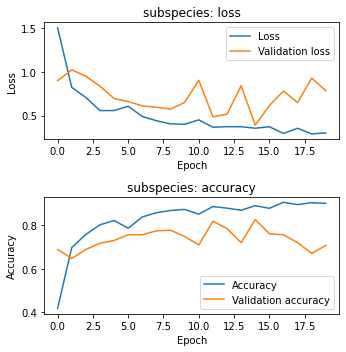

In [60]:
model_eval(training1,'subspecies')

In [62]:
# Print metrics
print("Classification report")
test_pred = model1.predict(test_X)
test_pred = np.argmax(test_pred, axis=1)
test_truth = np.argmax(test_y.values, axis=1)
print(metrics.classification_report(test_truth, test_pred, target_names=test_y.columns))

Classification report
                       precision    recall  f1-score   support

                   -1       0.52      0.93      0.67       108
1 Mixed local stock 2       0.41      0.95      0.57       102
  Carniolan honey bee       0.94      0.99      0.96       147
    Italian honey bee       0.99      0.59      0.74       754
    Russian honey bee       0.98      0.98      0.98       124
VSH Italian honey bee       0.41      0.98      0.58        54
    Western honey bee       0.80      1.00      0.89         4

             accuracy                           0.75      1293
            macro avg       0.72      0.92      0.77      1293
         weighted avg       0.87      0.75      0.76      1293



## Bee health classification

In [64]:
# Split/balance and plot the result
train_bees_bal, val_bees, test_bees = split_balance(df, 'health')

In [65]:
train_bees_bal['health'].value_counts()

missing queen                 581
hive being robbed             581
healthy                       581
few varrao, hive beetles      581
ant problems                  581
Varroa, Small Hive Beetles    581
Name: health, dtype: int64

In [66]:
val_bees['health'].value_counts()

healthy                       250
few varrao, hive beetles       51
Varroa, Small Hive Beetles     33
ant problems                   32
hive being robbed              17
missing queen                   5
Name: health, dtype: int64

In [67]:
test_bees['health'].value_counts()

healthy                       866
few varrao, hive beetles      139
ant problems                  117
Varroa, Small Hive Beetles    102
hive being robbed              61
missing queen                   8
Name: health, dtype: int64

In [68]:
# Will use balanced dataset as main
train_bees = train_bees_bal

In [69]:
# Call image preparation and one hot encoding from Bee subspecies section
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_bees, val_bees, test_bees, 'health')

In [74]:
# We'll stop training if no improvement after some epochs
earlystopper2 = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

In [75]:
# Build CNN model
model2=Sequential()
model2.add(Conv2D(5, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(10, kernel_size=3, activation='relu', padding='same'))
model2.add(Flatten())
model2.add(Dense(train_y.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 5)       140       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 5)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 10)        460       
_________________________________________________________________
flatten_2 (Flatten)          (None, 25000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 150006    
Total params: 150,606
Trainable params: 150,606
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Train
training2 = model2.fit_generator(generator.flow(train_X,train_y, batch_size=32)
                        ,epochs=20
                        ,validation_data=[val_X, val_y]
                        ,steps_per_epoch=50
                        ,callbacks=[earlystopper2])

  ...
    to  
  ['...']
Train for 50 steps, validate on 388 samples
Epoch 1/20
50/50 [==============================] - 9s 175ms/step - loss: 1.5244 - accuracy: 0.3367 - val_loss: 1.3099 - val_accuracy: 0.5515
Epoch 2/20
50/50 [==============================] - 8s 151ms/step - loss: 1.0096 - accuracy: 0.5944 - val_loss: 1.0246 - val_accuracy: 0.6057
Epoch 3/20
50/50 [==============================] - 7s 150ms/step - loss: 0.7620 - accuracy: 0.6875 - val_loss: 0.8383 - val_accuracy: 0.6701
Epoch 4/20
50/50 [==============================] - 8s 152ms/step - loss: 0.7398 - accuracy: 0.6959 - val_loss: 0.7364 - val_accuracy: 0.7191
Epoch 5/20
50/50 [==============================] - 8s 151ms/step - loss: 0.6843 - accuracy: 0.7100 - val_loss: 0.6863 - val_accuracy: 0.7113
Epoch 6/20
50/50 [==============================] - 8s 152ms/step - loss: 0.5965 - accuracy: 0.7231 - val_loss: 0.8090 - val_accuracy: 0.6985
Epoch 7/20
50/50 [==============================] - 8s 150ms/step - loss: 0.632

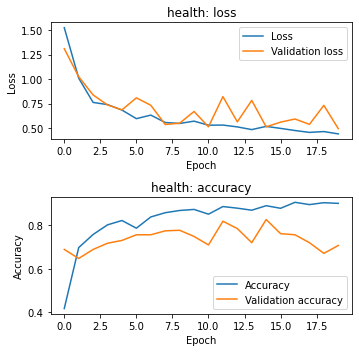

In [78]:
model_eval(training2,'health')

In [79]:
# Print metrics
print("Classification report")
test_pred = model2.predict(test_X)
test_pred = np.argmax(test_pred, axis=1)
test_truth = np.argmax(test_y.values, axis=1)
print(metrics.classification_report(test_truth, test_pred, target_names=test_y.columns))

Classification report
                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.45      0.94      0.61       102
              ant problems       0.83      0.95      0.89       117
  few varrao, hive beetles       0.41      0.18      0.25       139
                   healthy       0.97      0.85      0.90       866
         hive being robbed       0.49      0.90      0.64        61
             missing queen       0.42      1.00      0.59         8

                  accuracy                           0.80      1293
                 macro avg       0.60      0.80      0.65      1293
              weighted avg       0.83      0.80      0.79      1293

